In [78]:
from pyproj import Geod

geod = Geod(ellps='clrk66')

def calcdist(a, b):
    
    if len(a) == 3:
        lo, la, z = a
        lo2, la2, z2 = b
    else:
        lo, la = a
        lo2, la2 = b
        z = z2 = 0
        
    _, _, distx = geod.inv(lo, la, lo2, la2)
    distz = z2-z
    
    return (distx**2 + distz**2)**0.5


import xml.etree.ElementTree as ET
import numpy as np


class Track:
    def __init__(self, track, z=None):
        self.track = track = np.asarray(track)
        self.lon, self.lat = lon, lat = self.track.T
        self.z = z if z is not None else np.zeros_like(lon)
        
        # pre-calc
        self.dx = dx = np.array([calcdist(track[i], track[i-1]) for i in range(1, len(track))])
        self.dz = dz = np.diff(self.z)
        self.ds = (dx**2 + dz**2)**0.5
        self.dist = np.sum(self.ds)
        self.slope = self.dz/self.ds
                
    @classmethod
    def readgpx(cls, fname):
        tree = ET.parse(fname)
        root = tree.getroot()
        trk = list(root)[1]
        trkseg = list(trk)[1]
        track = np.array([(float(p.attrib['lon']), float(p.attrib['lat'])) for p in trkseg])
        z = np.array([float(list(p)[0].text) for p in trkseg])
        return cls(track, z)
    
    @property
    def line(self):
        import shapely.geometry as shg
        return shg.LineString(self.track)
    
        
def readgpx(fname):
    return Track.readgpx(fname)

load track

/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


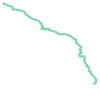

In [74]:
track = readgpx('capaccio-antonio-scario.gpx')
track.line

In [44]:
import matplotlib
%matplotlib notebook

<IPython.core.display.Javascript object>


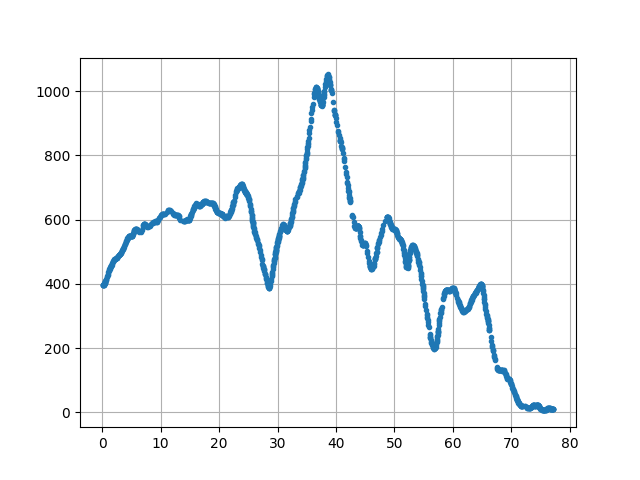

In [97]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(track.ds)*1e-3, track.z[1:],'.')
#plt.plot(np.cumsum(track.ds)*1e-3, track.slope,'.-')

plt.grid()

Drag forces based on 
https://en.wikipedia.org/wiki/Bicycle_performance


Air drag
https://en.wikipedia.org/wiki/Bicycle_performance#Air_drag

$P_{D}\,=\tfrac {1}{2}\,\rho \,v^{3}\,C_{D}\,A$ in still air

- $\rho$  is the air density, which is about 1.225 kg/m^3 at sea level and 15 deg. C.[19]
- $v $ is the speed relative to the road,
- $C_{D}\,A$ is a characteristic area times its associated drag coefficient.

Cd ~ 1

e.g. 
https://en.wikipedia.org/wiki/File:CyclingPowerComponents.svg

![power components](CyclingPowerComponents.svg.png)

notes on drag coef:
https://en.wikipedia.org/wiki/Drag_coefficient
- cube-like shape ~ 1 
- sphere shape ~ 0.5
- streamlined (tear) < 0.1
that is for a Reynolds number of 10^4 meaning laminar flow apparently (transition being 5 x 10^5)
Seems like the drag coefficient cd decreases with increase Re (though the drag itself increases)
road bike ~ 1

In [681]:
human = 100  # watt
efficiency = 0.8
mass = 100
s = 0.05  # slope in %

# gravity
g = 9.81

# air drag coefs
rho = 1.225
Cd = 1
A = 0.5  

# rolling
Crr = 0.005

def air_drag(v):
    return 1/2*rho*v**2*Cd*A

def gravity(s):
    return mass*g*s

def rolling():
    return mass*g*Crr

## at constant speed

In [682]:
v = 25 / 3.6 + np.zeros_like(track.ds)
dt = track.ds / v

Pd = air_drag(v)*v
Pg = gravity(track.slope)*v
Pr = rolling()*v
load = Pd+Pg+Pr

<IPython.core.display.Javascript object>


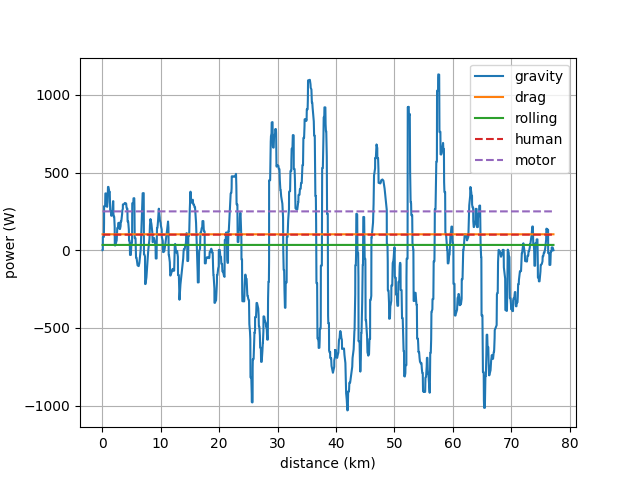

In [683]:
plt.figure()
dist = np.cumsum(track.ds)*1e-3
plt.plot(dist, Pg, label='gravity')
plt.plot(dist, Pd, label='drag')
plt.plot(dist, Pr, label='rolling')
plt.plot(dist, np.zeros_like(track.ds)+human, label='human', ls='--')
plt.plot(dist, np.zeros_like(track.ds)+motor, label='motor', ls='--')

plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('power (W)')
plt.legend()

<IPython.core.display.Javascript object>


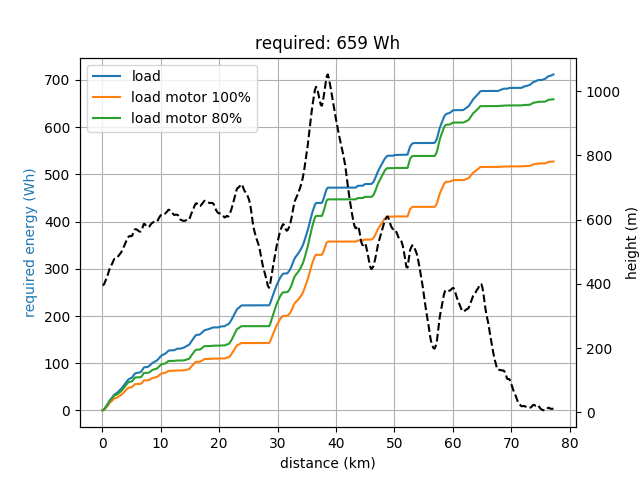

/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


Text(0, 0.5, 'height (m)')

In [684]:
plt.figure()
dist = np.cumsum(track.ds)*1e-3
cumload = np.cumsum(np.where(load > 0, load*dt/3600, 0))
cumload_motor = np.cumsum(np.where(load-human > 0, (load-human)*dt/3600, 0))
l, = plt.plot(dist, cumload, label='load')
plt.plot(dist, cumload_motor, label='load motor 100%')
plt.plot(dist, cumload_motor/efficiency, label='load motor {}%'.format(int(efficiency*100)))


plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('required energy (Wh)', color=l.get_color())
plt.legend()
plt.title('required: {:.0f} Wh'.format(cumload_motor[-1]/efficiency))
ax = plt.gca()
ax2 = ax.twinx()
l2, = ax2.plot(dist, track.z[1:], 'k--', label='elev')
ax2.set_ylabel('height (m)', color=l2.get_color())


## at constant power

In [779]:
from scipy.optimize import fmin

motor = 250
efficiency = 0.8
battery_usable_range = 0.9
human = 150
vmin = 15
vmax = 30
mass = 100


def calcload(v, s):
    Pd = air_drag(v)*v
    Pg = gravity(s)*v
    Pr = rolling()*v
    load = Pd+Pg+Pr
    return load

def balance_velocity(s, power):
    coefs = np.array([1/2*rho*Cd*A, 0, gravity(s)+rolling(), -power])
    roots = np.roots(coefs)
    realroots = [r.real for r in roots if r.imag == 0 and r.real > 0]
    assert len(realroots) == 1, str(realroots)+ ' slope: '+str(s)
    return realroots[0]    


done = False
vtarget = []
for s, dd in zip(track.slope, np.cumsum(track.ds)):
    #v = 25 / 3.6 + np.zeros_like(track.ds)
    #dt = ds / v
    if np.isnan(s):
        print('warning nan', dd)
        vtarget.append(vmax)
        continue
    v = balance_velocity(s, human+motor*efficiency)
    if v < vmin/3.6:
        #v = balance_velocity(s, human+max_motor*efficiency)
        v = vmin/3.6
        #print('using max motor:', int(v*3.6),'km/h with slope',int(s*100))
    if v > vmax/3.6:
        #print('limit max velocity with slope',int(s*100))
        v = vmax/3.6
    #v = min(v, vmax)
    #print(int(s*100), round(ds/1000,1), int(v*3.6), round(calcload(v, s),0))
    vtarget.append(v*3.6)
    
vtarget = np.array(vtarget)
traveltime = np.cumsum(track.ds / (vtarget/3.6) / 3600)
print('traveltime',traveltime[-1])

warning nan 77221.78750316065
traveltime 3.0701958744891207


<IPython.core.display.Javascript object>


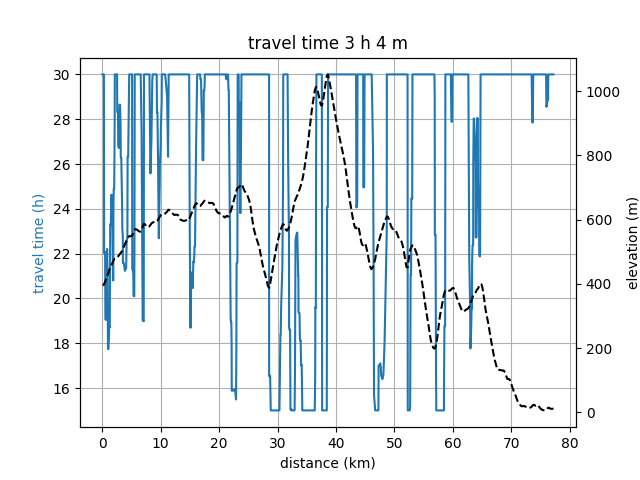

Text(0, 0.5, 'elevation (m)')

In [780]:
plt.figure()
traveltime = np.cumsum(track.ds / (vtarget/3.6) / 3600)
dist = np.cumsum(track.ds)*1e-3
l, = plt.plot(dist, vtarget)
#l, = plt.plot(dist, traveltime)
plt.grid()
plt.xlabel('distance (km)')
H = traveltime[-1]
h = int(H)
m = int((H-h)*60)
plt.title('travel time {} h {} m'.format(h, m))
#plt.ylabel('speed (km/h)')
plt.ylabel('travel time (h)', color=l.get_color())
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(dist, track.z[1:], 'k--', label='elev')
ax2.set_ylabel('elevation (m)')
#plt.legend()

In [781]:
v = vtarget/3.6
dt = track.ds / v
Pd = air_drag(v)*v
Pg = gravity(track.slope)*v
Pr = rolling()*v
load = Pd+Pg+Pr

<IPython.core.display.Javascript object>


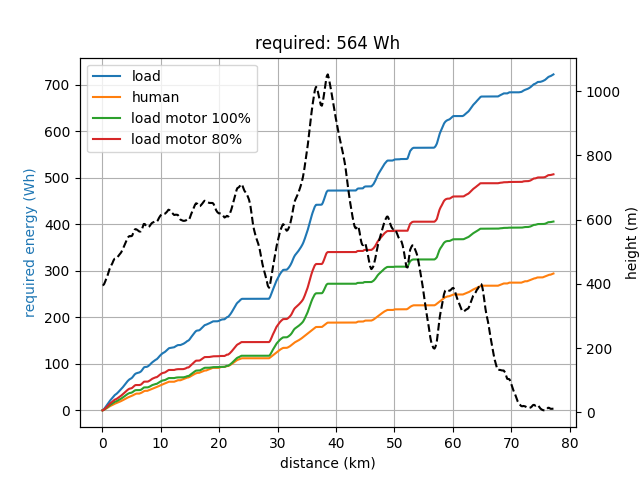

/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/perrette/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Text(0, 0.5, 'height (m)')

In [782]:
plt.figure()
dist = np.cumsum(track.ds)*1e-3
cumload = np.cumsum(np.where(load > 0, load*dt/3600, 0))
cumload_motor = np.cumsum(np.where(load-human > 0, (load-human)*dt/3600, 0))
cumload_human = np.cumsum(np.where(load-human > 0, (load*0+human)*dt/3600, 0))
l, = plt.plot(dist, cumload, label='load')
plt.plot(dist, cumload_human, label='human')
plt.plot(dist, cumload_motor, label='load motor 100%')
plt.plot(dist, cumload_motor/efficiency, label='load motor {}%'.format(int(efficiency*100)))


plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('required energy (Wh)', color=l.get_color())
plt.legend()
plt.title('required: {:.0f} Wh'.format(cumload_motor[-1]/efficiency/battery_usable_range))
ax = plt.gca()
ax2 = ax.twinx()
l2, = ax2.plot(dist, track.z[1:], 'k--', label='elev')
ax2.set_ylabel('height (m)', color=l2.get_color())


<IPython.core.display.Javascript object>


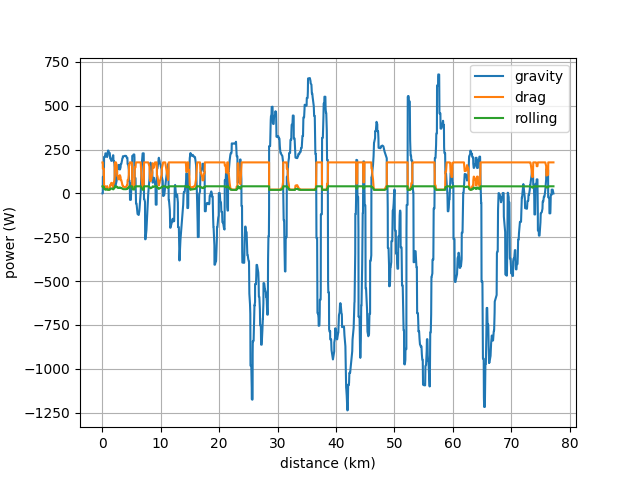

In [741]:
plt.figure()
dist = np.cumsum(track.ds)*1e-3
plt.plot(dist, Pg, label='gravity')
plt.plot(dist, Pd, label='drag')
plt.plot(dist, Pr, label='rolling')
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('power (W)')
plt.legend()